# 

In [12]:
#Je reviens à quelque chose de beaucoup plus simple. On va prouver que l'on obtient le bon FF pour STF classique. 
#Travaillons en mode dense, facile.
# This first version is for the classical STF. 
# Now, try to get to the domain-based STF...

import bempp.api 
import numpy as np
import mtf

from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

from mtf.utils import bhmie
from mtf.config import config
from mtf.functions import define_bempp_functions
from mtf.assembly.operators import GeneralizedBlockedOperator

from matplotlib import pyplot as plt
from decimal import Decimal
from bempp.api import ZeroBoundaryOperator

bempp.api.enable_console_logging()

tangential_trace, neumann_trace = define_bempp_functions(config)

M = 3
grid = bempp.api.shapes.multitrace_sphere(h=.2)

from mtf.utils import bhmie
from mtf.config import config
mtf.config.set_case("B")

k0, k1 = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]

polarization = config["polarization"]
direction = config["direction"]

eps_r = config["eps_rel"]
mu_r = config["mu_rel"]
mu0 = config["mu_ext"]

mu1 = mu_r * mu0

eta_r = np.sqrt(mu_r / eps_r)
k_int = k1
k_ext = k0

bempp:HOST:INFO: Created grid with id 8c73e582-bb6f-426a-8821-12cb0678b1c0. Elements: 1058. Edges: 1571. Vertices: 516


In [13]:
segments = [[10, 12], [20, 12]]
swapped_normals = [[], [12]]

dA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

p1dA = [bempp.api.function_space(grid, "DP", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

rA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "SNC", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]


bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.


In [14]:
multitrace_ops = []
multitrace_ops0 = []

for index in range(M-1):
  efie = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k1)
  mfie = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k1)
  multitrace_ops.append(GeneralizedBlockedOperator([[mfie, eta_r * efie],[-1/eta_r * efie, mfie]]))

  efie0 = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k0)
  mfie0 = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k0)
  multitrace_ops0.append(GeneralizedBlockedOperator([[mfie0, efie0],[-efie0, mfie0]]))


efie10 = bempp.api.operators.boundary.maxwell.electric_field(dA[0], rA[1], tA[1], k0)
mfie10 = bempp.api.operators.boundary.maxwell.magnetic_field(dA[0], rA[1], tA[1], k0)
A10 = GeneralizedBlockedOperator([[mfie10, efie10],[-efie10, mfie10]])

efie01 = bempp.api.operators.boundary.maxwell.electric_field(dA[1], rA[0], tA[0], k0)
mfie01 = bempp.api.operators.boundary.maxwell.magnetic_field(dA[1], rA[0], tA[0], k0)
A01 = GeneralizedBlockedOperator([[mfie01, efie01],[-efie01, mfie01]])

#A01 = multitrace_operator(sphere1, k_ext, target=sphere0, space_type='all_rwg', assembler="only_singular_part")

In [15]:
A = bempp.api.GeneralizedBlockedOperator([[multitrace_ops[0] + multitrace_ops0[0], A01],
                                          [A10, multitrace_ops[1] + multitrace_ops0[1]]])

rhs = [bempp.api.GridFunction(space=A.range_spaces[0], dual_space=A.dual_to_range_spaces[0], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[1], dual_space=A.dual_to_range_spaces[1], fun=neumann_trace),
       bempp.api.GridFunction(space=A.range_spaces[2], dual_space=A.dual_to_range_spaces[2], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[3], dual_space=A.dual_to_range_spaces[3], fun=neumann_trace)]

In [16]:
bempp.api.enable_console_logging()
sol = bempp.api.linalg.lu(A, rhs)

def plane_wave(point):
    return polarization * np.exp(1j * k0 * np.dot(point, direction))

/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)
66 warnings generated.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:417: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, [devices[i] for i in to_be_built_indices])
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.


66 warnings generated.
66 warnings generated.


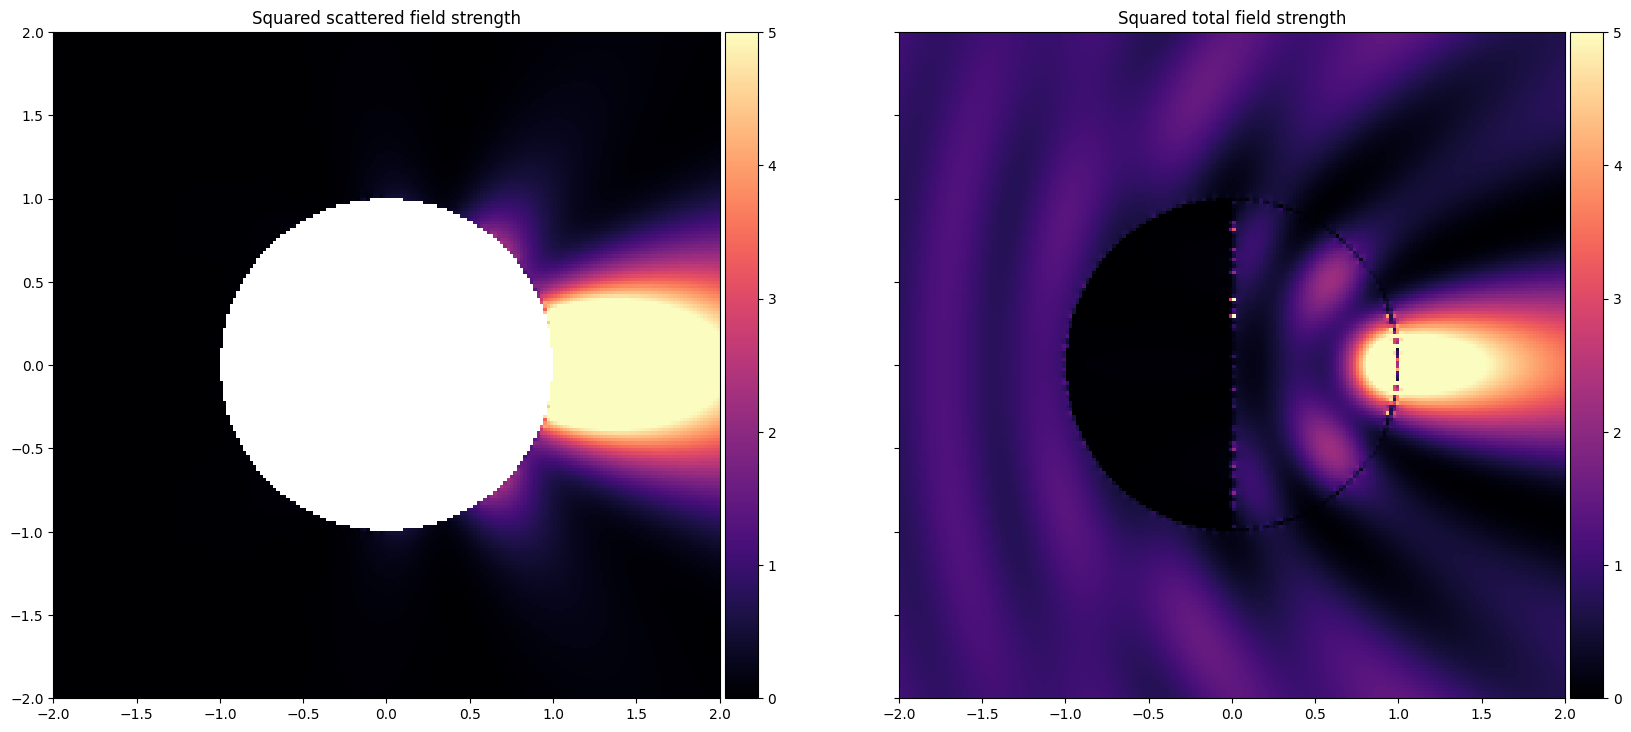

In [17]:
# Number of points in the x-direction
nx = 200

# Number of points in the y-direction
ny = 200

# Generate the evaluation points with numpy
x, y, z = np.mgrid[-2:2:nx * 1j, -2:2:ny * 1j, 0:0:1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

interior_indices0 = np.sum((points - np.array([x1]).T)**2, axis=0) < r1 ** 2
interior_indices1 = np.sum((points - np.array([x2]).T)**2, axis=0) < r2 ** 2
 
exterior_indices = ~interior_indices0 & ~interior_indices1


ext_points = points[:, exterior_indices]
int_points0 = points[:, interior_indices0]
int_points1 = points[:, interior_indices1]


mpot0_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, int_points0, k_int)
epot0_int = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, int_points0, k_int)
mpot0_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, ext_points, k_ext)
epot0_ext = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, ext_points, k_ext)

mpot1_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, int_points1, k_int)
epot1_int = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, int_points1, k_int)
mpot1_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, ext_points, k_ext)
epot1_ext = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, ext_points, k_ext)

exterior_values = -epot0_ext * sol[1] - mpot0_ext * sol[0]
exterior_values += -epot1_ext * sol[3] - mpot1_ext * sol[2]
interior_values0 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot0_int * sol[1] + mpot0_int * sol[0])
interior_values1 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot1_int * sol[3] + mpot1_int * sol[2])


from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = (20, 16) # Increase the figure size in the notebook

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, exterior_indices] = exterior_values

# Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for ext_ind in np.arange(points.shape[1])[exterior_indices]:
    total_field[:, ext_ind] = scattered_field[:, ext_ind] + plane_wave(points[:, ext_ind])
total_field[:, interior_indices0] = interior_values0
total_field[:, interior_indices1] = interior_values1
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, ny).T
total_image = squared_total_field.reshape(nx, ny).T
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

f0 = axes[0].imshow(scattered_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)
#axes[0].add_patch(
#    Circle((-1, 0), .4, facecolor='None', edgecolor='k', lw=5)
#)
#axes[0].add_patch(
#    Circle((1, 0), .4, facecolor='None', edgecolor='k', lw=5)
#)

axes[0].set_title("Squared scattered field strength")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f0, cax=cax)

f1 = axes[1].imshow(total_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)

axes[1].set_title("Squared total field strength")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f1, cax=cax)

plt.show()

In [18]:

number_of_angles = 3601
#angles = np.pi * np.linspace(0, 1, number_of_angles)

angles = config['angles']
unit_points = config['far_field_points']
far_field = np.zeros((3, number_of_angles), dtype='complex128')

for i in range(2):
    electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[2 * i + 1].space, unit_points, k_ext)
    magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[2 * i].space, unit_points, k_ext)    
    far_field += -electric_far * sol[2 * i + 1] - magnetic_far * sol[2 * i]
    

66 warnings generated.
66 warnings generated.


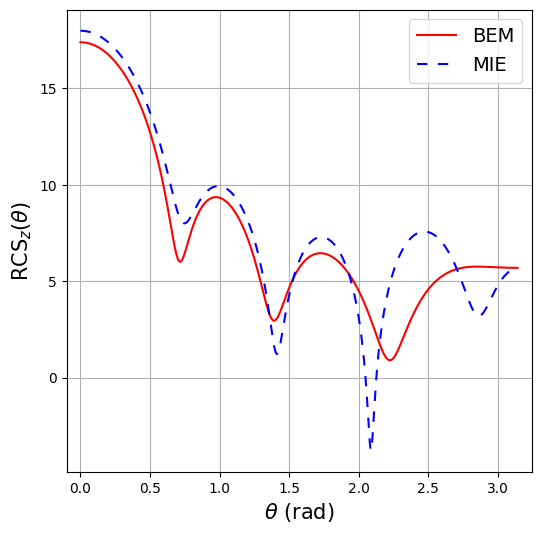

In [19]:
n = k_int / k_ext
refIndex = n
numAngles = 901
s1, s2, qext, qsca, qback, gsca = bhmie(k_ext, k_int / k_ext, numAngles)

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))


ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
#plt.ylim(ymin, ymax)
#plt.savefig("plots/RCSSphere.pdf")
plt.show()

In [23]:
Am = bempp.api.as_matrix(A.weak_form())

In [34]:
eig = np.linalg.eigvals(Am)

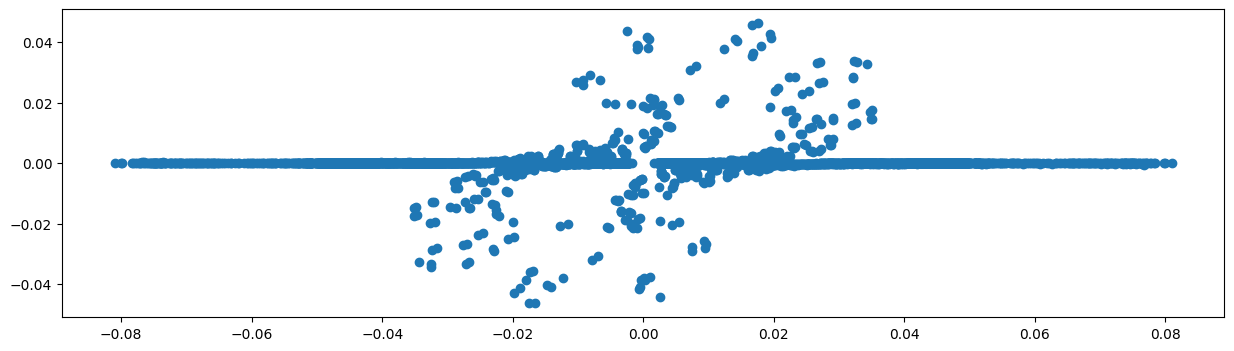

In [35]:
plt.scatter(np.real(eig), np.imag(eig))

In [37]:
np.linalg.cond(Am)

70.45018690373031